### Relationship between the US Unemployment Rate and Median House Sale Price in the US. 
#### Unemployment is an important indicators used to explain US economy performance, and it is proved to be highly correlated to recession. On the other hand, Housing market is always involved either directly or indirectly in US recession, especially in 2008.
#### This analysis wants to explore whether housing price can be used an a predictor to US recession (using umeployment rate to represent the recession cycle). They are very likely to have a negative correlation as housing market usually goes down when unemployment goes up. It's also very likely there would be lagging effects between the two, as housing market usually starts to go down before umemployment starts to go up. If there are measurable lags, how many months would that be? 

Data source from FRED:
1. Median Sales Price for New Houses Sold in the United States (MSPNHSUS)
2. Unemployment Rate (UNRATE)

# Table of Contents
1. [Uploading data & Creating Data Tables](#1)
2. [Exploratory Analysis](#2)
    1. [Stationarity Test (Remove Trends and Seasonality)](#2.1)
    2. [Correlation Between initial series](#2.2)
    3. [Benchmark Regression](#2.3)
3. [Lag Testing](#3)
    1. [Granger Causality up to 24 lags (look back max 24 months)](#3.1)
    2. [Regression test up to 24 lags](#3.2)
    3. [Run a sample regression against the benchmark regression ](#3.3)
4. [Result](#4)
    1. [Rerun the correlation graph again with diff # lag](#4.1)
    2. [Rerun time series with lag](#4.2)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

## Uploading data & Creating Data Tables <a name="1"></a>

In [37]:
# SQL Query:
"""
CREATE TABLE df_unrate (
    DATE date NOT NULL,
    UNRATE int NOT NULL,
    PRIMARY KEY (DATE)
);
"""

'\nCREATE TABLE df_unrate (\n    DATE date NOT NULL,\n    UNRATE int NOT NULL,\n    PRIMARY KEY (DATE)\n);\n'

In [3]:
# Read in the unemployment data
df_unrate = pd.read_csv (r'D:\JupyterNotebook\HG_Vora\UNRATE.csv')
df_unrate = df_unrate.set_index(pd.to_datetime(df_unrate['DATE']))
df_unrate = df_unrate.drop(['DATE'], axis = 1)
df_unrate.head()

,UNRATE
DATE,
1948-01-01,3.4
1948-02-01,3.8
1948-03-01,4.0
1948-04-01,3.9
1948-05-01,3.5


In [38]:
# SQL Query:
"""
CREATE TABLE df_house (
    DATE date NOT NULL,
    MSPNHSUS int NOT NULL,
    PRIMARY KEY (DATE)
);
"""

'\nCREATE TABLE df_house (\n    DATE date NOT NULL,\n    MSPNHSUS int NOT NULL,\n    PRIMARY KEY (DATE)\n);\n'

In [4]:
# Read in the median housing price data
df_house = pd.read_csv (r'D:\JupyterNotebook\HG_Vora\MSPNHSUS.csv')
df_house = df_house.set_index(pd.to_datetime(df_house['DATE']))
df_house = df_house.drop(['DATE'], axis = 1)
df_house.head()

,MSPNHSUS
DATE,
1963-01-01,17200.0
1963-02-01,17700.0
1963-03-01,18200.0
1963-04-01,18200.0
1963-05-01,17500.0


In [39]:
# SQL Query:
"""
SELECT df_unrate.DATE, df_unrate.UNRATE, df_house.MSPNHSUS
FROM df_unrate, df_house
WHERE df_unrate.DATE = df_house.DATE
ORDER BY df_unrate.DATE;
"""
#or: 
"""
SELECT df_unrate.DATE, df_unrate.UNRATE, df_house.MSPNHSUS
FROM df_unrate
LEFT JOIN df_house ON df_unrate.DATE = df_house.DATE
ORDER BY df_unrate.DATE;
"""

'\nSELECT df_unrate.DATE, df_unrate.UNRATE, df_house.MSPNHSUS\nFROM df_unrate\nLEFT JOIN df_house ON df_unrate.DATE = df_house.DATE\nORDER BY df_unrate.DATE;\n'

In [5]:
#Merge them to the same dataset 'master' dataset
master =  pd.concat([df_unrate, df_house], axis=1)
master = master.dropna()
master.head()

,UNRATE,MSPNHSUS
DATE,,
1963-01-01,5.7,17200.0
1963-02-01,5.9,17700.0
1963-03-01,5.7,18200.0
1963-04-01,5.7,18200.0
1963-05-01,5.9,17500.0


## Exploratory Analysis/Visualize the Data <a name="2"></a>

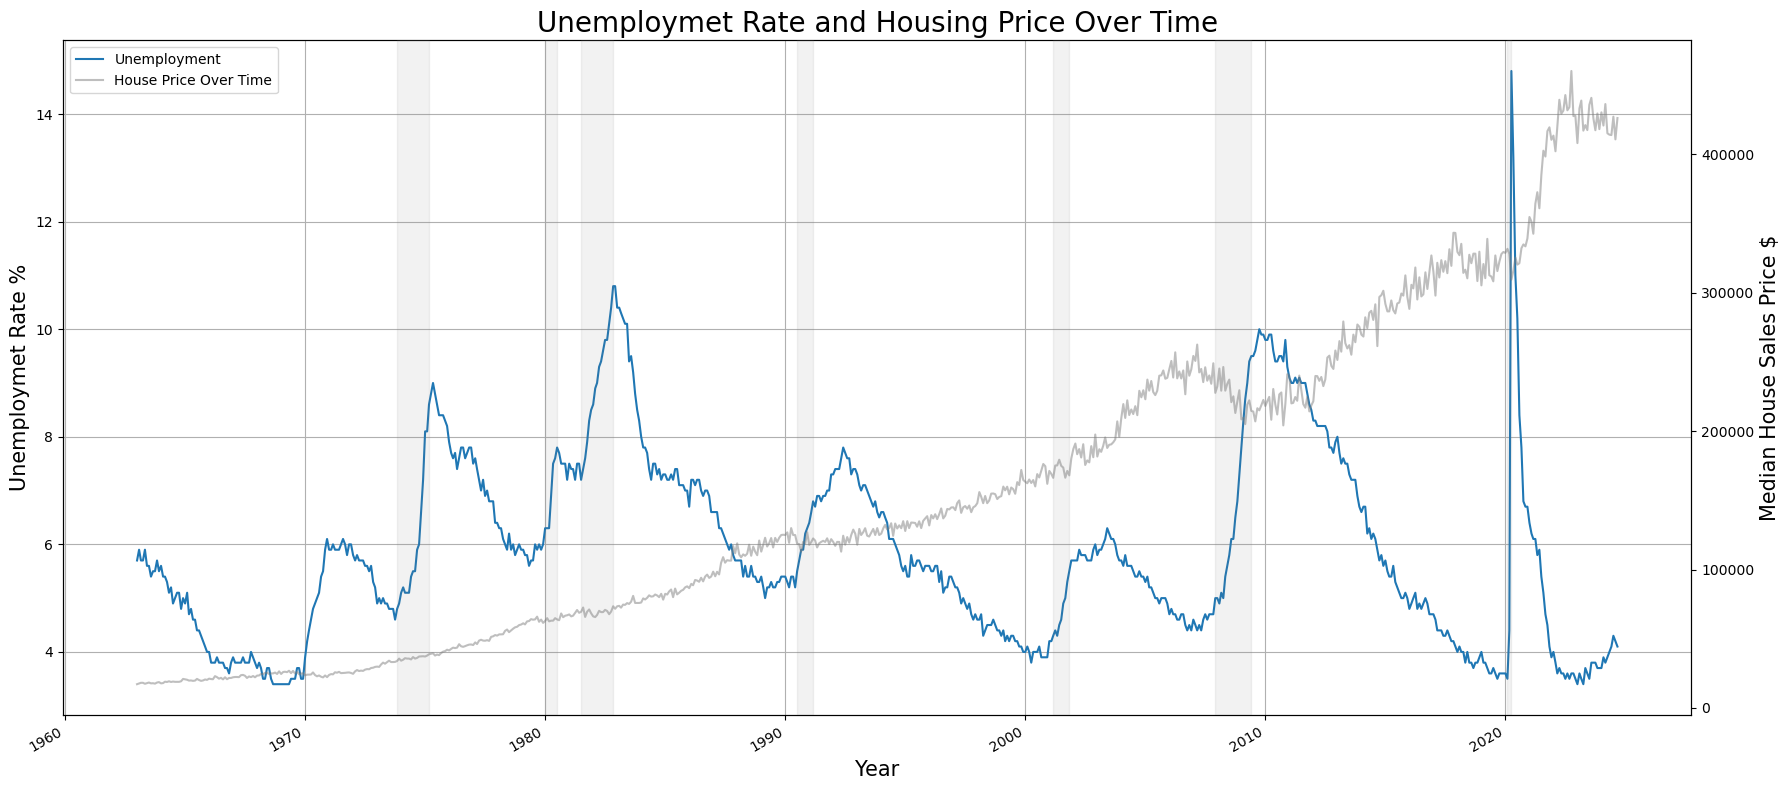

In [6]:
from datetime import datetime, date

# Created a time series graph to visualize the raw data 
fig, ax1 = plt.subplots(figsize = (18,8))
line1 = ax1.plot(master.index, 'UNRATE', data=master, color = 'tab:blue',label = 'Unemployment')
ax1.set_xlabel('Year',fontdict={'fontsize': 15, 'fontweight': 'medium'})
ax1.set_ylabel('Unemploymet Rate %',fontdict={'fontsize': 15, 'fontweight': 'medium'})
ax1.set_title('Unemploymet Rate and Housing Price Over Time', fontdict={'fontsize': 20, 'fontweight': 'medium'})
ax1.grid(True)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
line2 = ax2.plot(master.index, 'MSPNHSUS', data=master, color = 'tab:gray', alpha=0.5,label = 'House Price Over Time')
ax2.tick_params(axis = 'y')
ax2.set_ylabel('Median House Sales Price $', size = 15)

lines = line1 + line2
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper left')

#Year periods for recessions defined by Wikipedia list of recessions
ax3 = ax1.twinx()
ax3.axvspan(datetime(1980, 1, 1),datetime(1980, 7, 1),alpha=0.1,color='gray')
ax3.axis('off')

ax4 = ax1.twinx()
ax4.axvspan(datetime(1981, 7, 1),datetime(1982, 11, 1),alpha=0.1,color='gray')
ax4.axis('off')

ax5 = ax1.twinx()
ax5.axvspan(datetime(1990, 7, 1),datetime(1991, 3, 1),alpha=0.1,color='gray')
ax5.axis('off')

ax6 = ax1.twinx()
ax6.axvspan(datetime(2001, 3, 1),datetime(2001, 11, 1),alpha=0.1,color='gray')
ax6.axis('off')

ax7 = ax1.twinx()
ax7.axvspan(datetime(2007, 12, 1),datetime(2009, 6, 1),alpha=0.1,color='gray')
ax7.axis('off')

ax8 = ax1.twinx()
ax8.axvspan(datetime(2020, 2, 1),datetime(2020, 4, 1),alpha=0.1,color='gray')
ax8.axis('off')

ax9 = ax1.twinx()
ax9.axvspan(datetime(1973, 11, 1),datetime(1975, 3, 1),alpha=0.1,color='gray')
ax9.axis('off')


# rotates and right aligns the x labels, and moves the bottom of the
# axes up to make room for them
# otherwise the right y-label is slightly clipped
fig.autofmt_xdate()
fig.tight_layout()  
plt.show()

# Talking points:
# 1. Umeployment Rate is highly correlated with recession 
# 2. Umemployment go up during recession
# 3. Housing price starts to go down before recession

### 1. Stationarity Test (Remove Trends and Seasonality) <a name="2.1"></a>

In [7]:
# use adfuller test to test if a time serie is stationary or not 
# if p-value < 0.05, it is stationary and we can use this series for analysis
# if p-value > 0.05, it is not stationary and we should make it stationary first (take the first difference or use % change)
from statsmodels.tsa.stattools import adfuller
def testStationary(df, col, resultdf, Description):
    dftest = adfuller(df[col], autolag = 'AIC')
    print('Column: ', col)
    print("P-Value : ", dftest[1])
    if dftest[0] < dftest[4]["5%"]:
        print('reject Ho - it is stationary')
        result = 'stationary'
    else:
        print('failed to reject Ho - it is non-stationary')
        result = 'non-stationary'
    
    # Create a new row as a dictionary
    new_row = [col, dftest[1], result, Description]
    # Append the new row
    resultdf.loc[len(resultdf)] = new_row

In [40]:
# SQL Query:
"""
CREATE TABLE stationary_df (
    Column varchar(255) NOT NULL,
    P-Value int NOT NULL,
    P-Result varchar(255) NOT NULL,
    Description varchar(255),
    PRIMARY KEY (Column)
);
"""

'\nCREATE TABLE stationary_df (\n    Column varchar(255) NOT NULL,\n    P-Value int NOT NULL,\n    P-Result varchar(255) NOT NULL,\n    Description varchar(255),\n    PRIMARY KEY (Column)\n);\n'

In [8]:
#result dataframe for stationary test
stationary_df = pd.DataFrame(columns=['Column','P-Value', 'Result', 'Description'])

In [41]:
# SQL Query:
"""
INSERT INTO stationary_df (Column, P-Value, Result, Description)
VALUES ('UNRATE', 0.016579, 'stationary', 'Unemployment Rate'');
"""

"\nINSERT INTO stationary_df (Column, P-Value, Result, Description)\nVALUES ('UNRATE', 0.016579, 'stationary', 'Unemployment Rate'');\n"

In [9]:
#FRED says this time series is seasonaly adjusted. It is stationary but P-value is not very low
testStationary(master, 'UNRATE',stationary_df, 'Unemployment Rate')

Column:  UNRATE
P-Value :  0.016579098664769233
reject Ho - it is stationary


In [10]:
#This doesn't look stationary at all, need to remove trends and not use the raw data in analysis
testStationary(master, 'MSPNHSUS',stationary_df, 'Median Housing Price Over Time')

Column:  MSPNHSUS
P-Value :  0.9973931585502119
failed to reject Ho - it is non-stationary


In [42]:
# SQL Query:
"""
SELECT *, 
    (LAG(MSPNHSUS, 1, 0) over (ORDER BY DATE)) - MSPNHSUS as house_diff  
    ((LAG(MSPNHSUS, 1, 0) over (ORDER BY DATE)) - MSPNHSUS)/(LAG(MSPNHSUS, 1, 0) over (ORDER BY DATE)) as house_return  
FROM master
ORDER BY DATE
"""

'\nSELECT *, \n    (LAG(MSPNHSUS, 1, 0) over (ORDER BY DATE)) - MSPNHSUS as house_diff  \n    ((LAG(MSPNHSUS, 1, 0) over (ORDER BY DATE)) - MSPNHSUS)/(LAG(MSPNHSUS, 1, 0) over (ORDER BY DATE)) as house_return  \nFROM master\nORDER BY DATE\n'

In [11]:
#removing trend of the housing data
master['house_diff']=master['MSPNHSUS'].diff(1)
master['house_return']= master['MSPNHSUS'].pct_change(1)
master = master.dropna()
master.tail()

,UNRATE,MSPNHSUS,house_diff,house_return
DATE,,,,
2024-05-01,4.0,414300.0,-1000.0,-0.002408
2024-06-01,4.1,414000.0,-300.0,-0.000724
2024-07-01,4.3,427300.0,13300.0,0.032126
2024-08-01,4.2,410900.0,-16400.0,-0.038381
2024-09-01,4.1,426300.0,15400.0,0.037479


In [12]:
# this is staiory and we can use this in analysis
testStationary(master, 'house_diff',stationary_df, 'First diff of housing Price')

Column:  house_diff
P-Value :  1.0845421411142084e-06
reject Ho - it is stationary


In [13]:
# this is staiory and we can use this in analysis
testStationary(master, 'house_return',stationary_df, 'Return of housing Price')

Column:  house_return
P-Value :  2.3239647603020555e-05
reject Ho - it is stationary


In [14]:
# To summary
stationary_df

,Column,P-Value,Result,Description
0,UNRATE,0.016579,stationary,Unemployment Rate
1,MSPNHSUS,0.997393,non-stationary,Median Housing Price Over Time
2,house_diff,0.000001,stationary,First diff of housing Price
3,house_return,0.000023,stationary,Return of housing Price


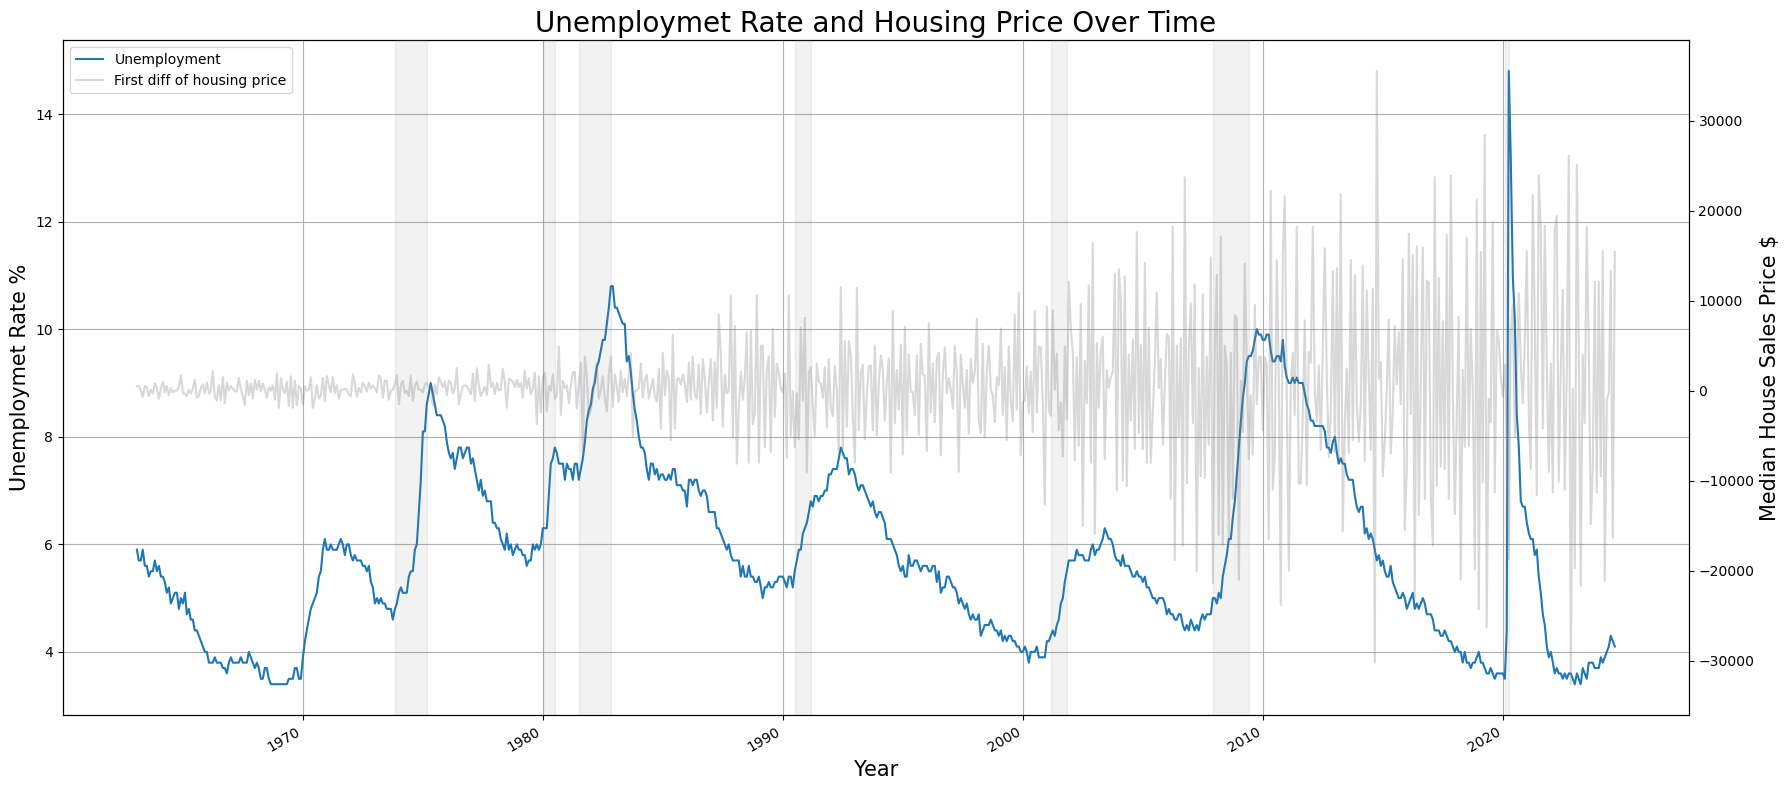

In [15]:
from datetime import datetime, date

# Created a time series graph to visualize the stationary data (used 1st diff housing price vs. unemployment rate)
fig, ax1 = plt.subplots(figsize = (18,8))
line1 = ax1.plot(master.index, 'UNRATE', data=master, color = 'tab:blue',label = 'Unemployment')
ax1.set_xlabel('Year',fontdict={'fontsize': 15, 'fontweight': 'medium'})
ax1.set_ylabel('Unemploymet Rate %',fontdict={'fontsize': 15, 'fontweight': 'medium'})
ax1.set_title('Unemploymet Rate and Housing Price Over Time', fontdict={'fontsize': 20, 'fontweight': 'medium'})
ax1.grid(True)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
line2 = ax2.plot(master.index, 'house_diff', data=master, color = 'tab:gray', alpha=0.3,label = 'First diff of housing price')
ax2.tick_params(axis = 'y')
ax2.set_ylabel('Median House Sales Price $', size = 15)

lines = line1 + line2
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper left')

#Year period for recessions defined by Wikipedia list of recessions
ax3 = ax1.twinx()
ax3.axvspan(datetime(1980, 1, 1),datetime(1980, 7, 1),alpha=0.1,color='gray')
ax3.axis('off')

ax4 = ax1.twinx()
ax4.axvspan(datetime(1981, 7, 1),datetime(1982, 11, 1),alpha=0.1,color='gray')
ax4.axis('off')

ax5 = ax1.twinx()
ax5.axvspan(datetime(1990, 7, 1),datetime(1991, 3, 1),alpha=0.1,color='gray')
ax5.axis('off')

ax6 = ax1.twinx()
ax6.axvspan(datetime(2001, 3, 1),datetime(2001, 11, 1),alpha=0.1,color='gray')
ax6.axis('off')

ax7 = ax1.twinx()
ax7.axvspan(datetime(2007, 12, 1),datetime(2009, 6, 1),alpha=0.1,color='gray')
ax7.axis('off')

ax8 = ax1.twinx()
ax8.axvspan(datetime(2020, 2, 1),datetime(2020, 4, 1),alpha=0.1,color='gray')
ax8.axis('off')

ax9 = ax1.twinx()
ax9.axvspan(datetime(1973, 11, 1),datetime(1975, 3, 1),alpha=0.1,color='gray')
ax9.axis('off')


fig.autofmt_xdate()
fig.tight_layout()
plt.show()

### 2. Correlation Between initial series  <a name="2.2"></a>

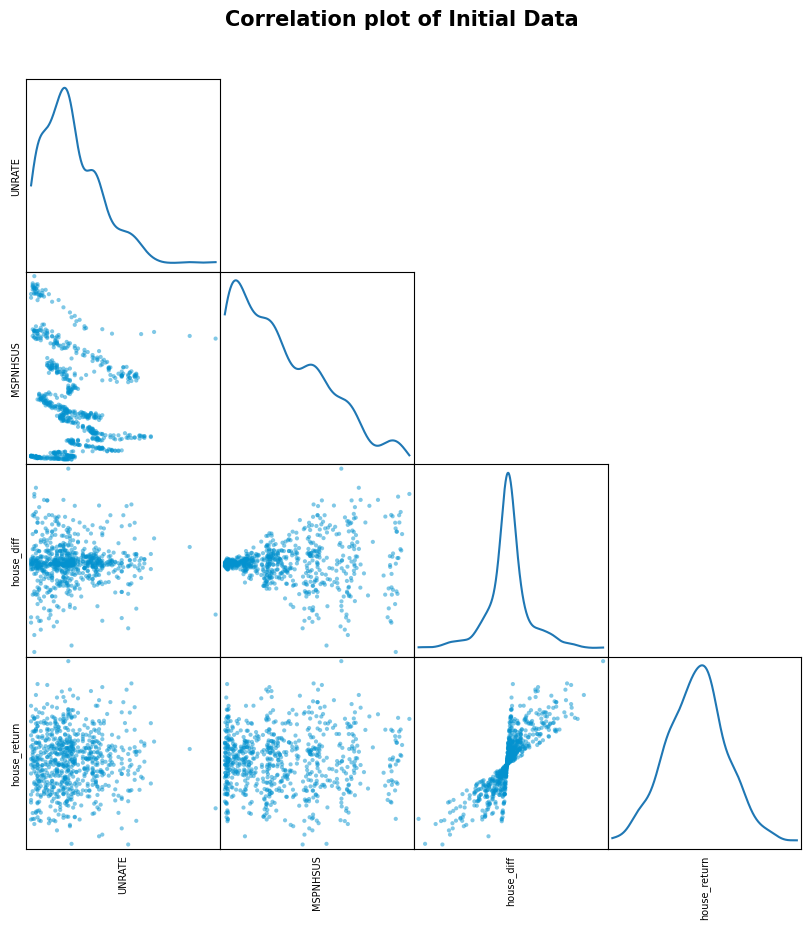

In [16]:
from matplotlib.ticker import FormatStrFormatter
from pandas.plotting import scatter_matrix
from sklearn import datasets

# create a correlation plot for columns defined below
#diagonal plot is graphed by kernel density estimation (KDE)
ax = scatter_matrix(master[['UNRATE', 'MSPNHSUS', 'house_diff','house_return']], 
                    color="#0392cf", alpha=0.5, figsize=(10, 10), diagonal='kde', marker = '.')

for i in range(np.shape(ax)[0]):
    for j in range(np.shape(ax)[1]):
        if i < j:
            ax[i,j].set_visible(False)

for ax in ax.ravel():
    ax.set_xlabel(ax.get_xlabel().replace(' ', '\n'), fontsize = 7, rotation = 90, weight = 'medium')
    ax.set_ylabel(ax.get_ylabel().replace(' ', '\n'), fontsize = 7, rotation = 90, weight = 'medium')
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.yaxis.set_ticks([])
    ax.xaxis.set_ticks([])
    
plt.suptitle('Correlation plot of Initial Data',size = 15, weight = 'bold',va = 'bottom', x= 0.5, y= 0.93)

handles = [plt.plot([],[],color=plt.cm.brg(i/2.), ls="", marker="o", \
                    markersize=np.sqrt(10))[0] for i in range(3)]
handles = [handles[0],handles[2],handles[1]]
plt.show()

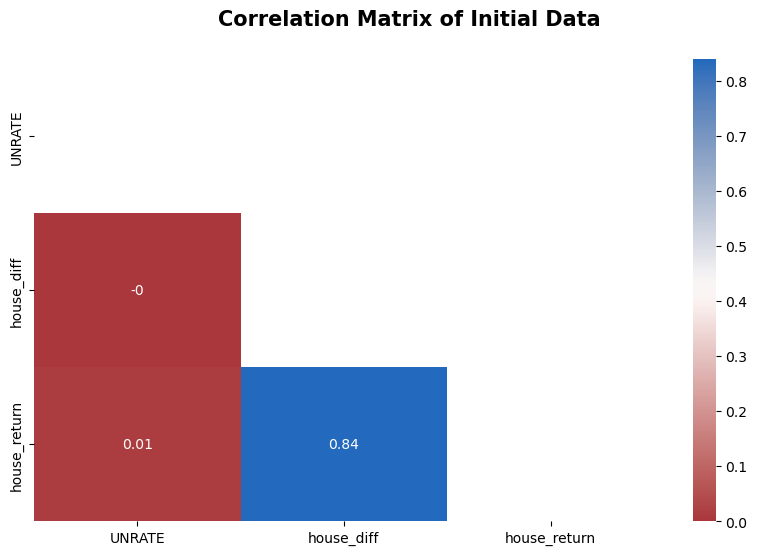

In [17]:
import seaborn as sns

# create a correlation matrix for columns defined below
corr_matrix = master[['UNRATE', 'house_diff','house_return']] 
np.bool = np.bool_
corr =round(corr_matrix.corr(),2)

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, annot_kws = {'size':10}, cmap = 'vlag_r', xticklabels = corr.columns.values, 
            yticklabels = corr.columns.values, annot = True, mask = mask)
heat_map = plt.gcf()
heat_map.set_size_inches(10,6)
plt.suptitle('Correlation Matrix of Initial Data',size = 15, weight = 'bold',va = 'bottom', x= 0.5, y= 0.93)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.show()

### 3. Benchmark Regression  <a name="2.3"></a>

In [18]:
# run a sample regression against the unemployment rate
x = master[['house_diff', 'house_return']]
reg_model = sm.OLS(master['UNRATE'],x)
result = reg_model.fit()
print(result.summary())
# R square is only 0.023

                                 OLS Regression Results                                
Dep. Variable:                 UNRATE   R-squared (uncentered):                   0.023
Model:                            OLS   Adj. R-squared (uncentered):              0.020
Method:                 Least Squares   F-statistic:                              8.548
Date:                Mon, 02 Dec 2024   Prob (F-statistic):                    0.000214
Time:                        11:58:22   Log-Likelihood:                         -2384.7
No. Observations:                 740   AIC:                                      4773.
Df Residuals:                     738   BIC:                                      4783.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

#### No Strong correlation can be found from the above initial analysis. We see some negative correlation but not a lot. If our hypothesis is correct, we should see a higher correlation/causation when we consider more lags

## Lag Testing <a name="3"></a>

### 1. Granger Causality up to 24 lags (look back max 24 months)  <a name="3.1"></a>

In [19]:
from statsmodels.tsa.stattools import grangercausalitytests
"""
The Null hypothesis for grangercausalitytests is that the time series in the second column, x2,
does NOT Granger cause the time series in the first column, x1. 

Grange causality means that past values of x2 have a statistically significant effect
on the current value of x1.

H1 Hypothesis: X2 (second column) is the granger cause to X1, Because the p value<0.05 
"""
#'house_diff' granger calse the 'UNRATE' by 11 lags
granger_test_result = sm.tsa.stattools.grangercausalitytests(master[['UNRATE','house_diff']], maxlag=24, verbose=False)

results = []
for lag, test_results in granger_test_result.items():
    p_value = test_results[0]['ssr_ftest'][1]  # Extract p-value from F-test
    results.append({'Granger Causality Lag': lag, 'P-Value': p_value})

p_value_df = pd.DataFrame(results)

# Display the resulting DataFrame
p_value_df.head()

C:\Users\siaha\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


,Granger Causality Lag,P-Value
0,1,0.392996
1,2,0.649380
2,3,0.624370
3,4,0.717303
4,5,0.747474


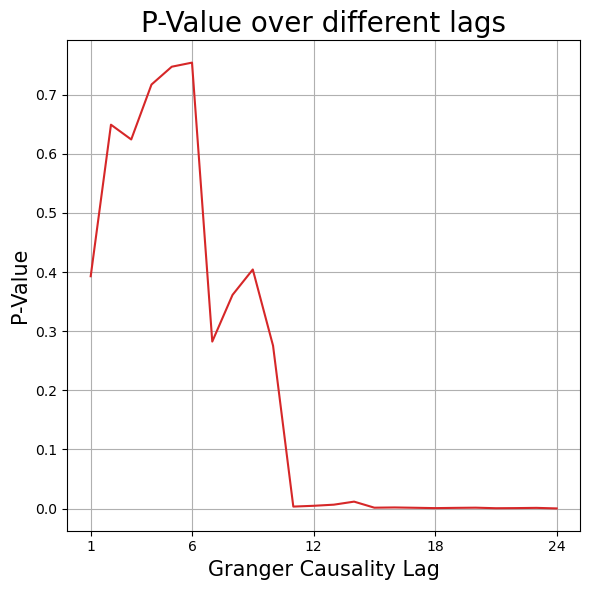

In [34]:
# Created a graph to visualize the grangercausalitytests data
# The p-value is less than 0.05 starting at the 11th lag
fig, ax1 = plt.subplots(figsize=(6,6))
ax1.plot('Granger Causality Lag', 'P-Value', data=p_value_df, color='tab:red', label='Granger Causality P Value')
ax1.set_xlabel('Granger Causality Lag', fontdict={'fontsize': 15, 'fontweight': 'medium'})
ax1.set_ylabel('P-Value', fontdict={'fontsize': 15, 'fontweight': 'medium'})
ax1.set_title('P-Value over different lags', fontdict={'fontsize': 20, 'fontweight': 'medium'})
ax1.set_xticks(np.linspace(min(p_value_df['Granger Causality Lag']), max(p_value_df['Granger Causality Lag']), 5, dtype=int))
ax1.grid(True)

fig.tight_layout() 
plt.show()

### 2. Regression test up to 24 lags <a name="3.2"></a>

In [22]:
# Make a dataframe to store the result: 
# one for R square and change in R square and % of valid lags with Pvalue < 5%
# Graph R-square for each lag
    
PValue_df = pd.DataFrame()
R2_result = []    
    
nlag = 20
prevR2 = 0

for i in range(1,nlag+1):
    #print(i)
    master_loop = master.copy()
    #running = i.copy()
    column_names = ['house_diff']
    pointer = 'lag' + '_' + str(i)
    current_lag = i
    print("Number of lag : ", str(i))
    while i > 0:
        text = 'lag' + '_' + str(i)
        master_loop[text] = master_loop['house_diff'].shift(i)
        column_names.append(text)
        i = i - 1
        #print(i+1)
    #print(" ")
    master_loop = master_loop.dropna()
    
    x = master_loop[column_names] 
    reg_model = sm.OLS(master_loop['UNRATE'],x)
    result = reg_model.fit()
    print("R-squared : ", result.rsquared)
    print("P-value : ")
    print(result.pvalues)
    print(" ")
    changeR2 = result.rsquared - prevR2
    prevR2 = result.rsquared
    temp_df = pd.DataFrame(result.pvalues).rename(columns={0:pointer})
    PValue_df =  pd.concat([PValue_df, temp_df], axis=1)
    R2_result.append({'Total Lag': current_lag, 'R2': result.rsquared, 'Change in R2' : changeR2 })

Number of lag :  1
R-squared :  0.017400307873512988
P-value : 
house_diff    0.001692
lag_1         0.002075
dtype: float64
 
Number of lag :  2
R-squared :  0.03448898029790659
P-value : 
house_diff    0.000256
lag_2         0.000328
lag_1         0.000008
dtype: float64
 
Number of lag :  3
R-squared :  0.05602079606664978
P-value : 
house_diff    2.997322e-05
lag_3         4.776744e-05
lag_2         2.473094e-07
lag_1         2.154981e-07
dtype: float64
 
Number of lag :  4
R-squared :  0.07713872375373987
P-value : 
house_diff    2.351032e-05
lag_4         4.874011e-05
lag_3         2.665491e-08
lag_2         4.468274e-09
lag_1         1.609946e-08
dtype: float64
 
Number of lag :  5
R-squared :  0.09958464372027098
P-value : 
house_diff    1.219588e-05
lag_5         2.330451e-05
lag_4         1.653627e-08
lag_3         2.945962e-10
lag_2         2.004356e-10
lag_1         7.877166e-09
dtype: float64
 
Number of lag :  6
R-squared :  0.11983919640540819
P-value : 
house_diff    5.

In [23]:
R2_df = pd.DataFrame(R2_result)
R2_df.head()

,Total Lag,R2,Change in R2
0,1,0.017400,0.017400
1,2,0.034489,0.017089
2,3,0.056021,0.021532
3,4,0.077139,0.021118
4,5,0.099585,0.022446


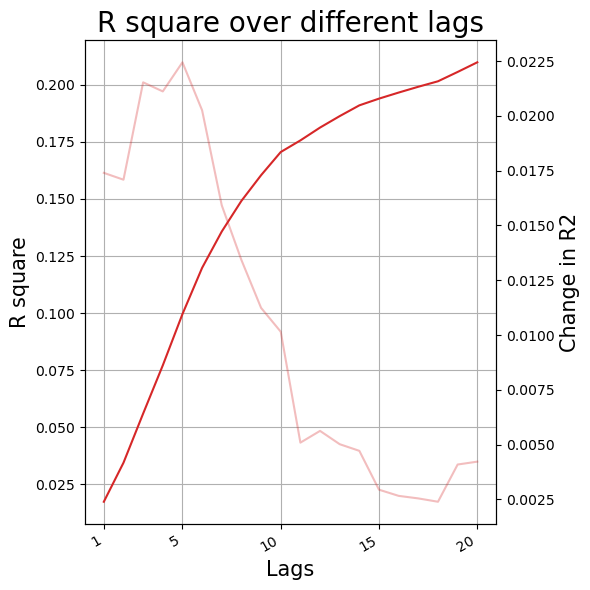

In [25]:
# Created a graph to visualize the R2 data
fig, ax1 = plt.subplots(figsize=(6,6))
ax1.plot('Total Lag', 'R2', data=R2_df, color='tab:red', label='R square')
ax1.set_xlabel('Lags', fontdict={'fontsize': 15, 'fontweight': 'medium'})
ax1.set_ylabel('R square', fontdict={'fontsize': 15, 'fontweight': 'medium'})
ax1.set_title('R square over different lags', fontdict={'fontsize': 20, 'fontweight': 'medium'})
ax1.set_xticks(np.linspace(min(R2_df['Total Lag']), max(R2_df['Total Lag']), 5, dtype=int))
ax1.grid(True)

ax2 = ax1.twinx() 
ax2.plot('Total Lag', 'Change in R2', data=R2_df, color='tab:red', alpha=0.3, label='House Price')
ax2.tick_params(axis='y')
ax2.set_ylabel('Change in R2', size=15)

fig.tight_layout()
plt.show()
# Key talking points:
# 1. we can see that the change in R2 suddenly starts to drop at the 11th lag
# 2. the R2 graph line is more flat after 11th lag 

### 3. Run a sample regression against the benchmark regression  <a name="3.3"></a>

In [43]:
# SQL Query:
"""
SELECT DATE, NRATE
INTO y
FROM master_loop
ORDER BY DATE
"""
"""
SELECT DATE, house_diff,house_return, lag_11,
    lag_10,lag_9, lag_8, lag_7, lag_6,
    lag_5, lag_4, lag_3, lag_2, lag_1
INTO x
FROM master_loop
ORDER BY DATE
"""

'\nSELECT DATE, house_diff,house_return, lag_11,\n    lag_10,lag_9, lag_8, lag_7, lag_6,\n    lag_5, lag_4, lag_3, lag_2, lag_1\nINTO x\nFROM master_loop\nORDER BY DATE\n'

In [26]:
# define x and y datasets to run a sample regression test against the benchmark
# benchmark model is the regression we used earlier
x = master_loop[['house_diff','house_return', 'lag_11', 'lag_10', 'lag_9', 'lag_8', 'lag_7', 'lag_6',
       'lag_5', 'lag_4', 'lag_3', 'lag_2', 'lag_1']]
y = master_loop['UNRATE']

In [27]:
# split into test and train data
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(x,y, random_state = 4, test_size = 0.2)

In [28]:
# split test and train data for benchmark model and regression model
x_bench_train = xtrain[['house_diff','house_return']]
x_bench_test = xtest[['house_diff','house_return']]
x_lag_train = xtrain[['lag_11', 'lag_10', 'lag_9', 'lag_8', 'lag_7', 'lag_6',
       'lag_5', 'lag_4', 'lag_3', 'lag_2', 'lag_1']]
x_lag_test = xtest[['lag_11', 'lag_10', 'lag_9', 'lag_8', 'lag_7', 'lag_6',
       'lag_5', 'lag_4', 'lag_3', 'lag_2', 'lag_1']]

In [29]:
# Benchmark model 
model = sm.OLS(ytrain, x_bench_train)
results = model.fit()
# Test the Model
y_pred = results.predict(x_bench_test)
# Evaluate Performance (R² on Test Data)
ss_total = np.sum((ytest - ytest.mean())**2)  # Total Sum of Squares
ss_residual = np.sum((ytest - y_pred)**2)  # Residual Sum of Squares
r_squared_test = 1 - (ss_residual / ss_total)
mse_test = np.mean((ytest - y_pred)**2)
print("The R-squre of trained model is: ", results.rsquared)
print("The MSE of trained model is: ", results.mse_resid)
print("The R-squre of tested model is: ", r_squared_test)
print("The MSE of tested model is: ", mse_test)

The R-squre of trained model is:  0.01876029284398051
The MSE of trained model is:  37.72287161365547
The R-squre of tested model is:  -11.168353344691054
The MSE of tested model is:  35.26831380893154


In [30]:
# lag model 
model = sm.OLS(ytrain, x_lag_train)
results = model.fit()
# Test the Model
y_pred = results.predict(x_lag_test)
# Evaluate Performance (R² on Test Data)
ss_total = np.sum((ytest - ytest.mean())**2)  # Total Sum of Squares
ss_residual = np.sum((ytest - y_pred)**2)  # Residual Sum of Squares
r_squared_test = 1 - (ss_residual / ss_total)
mse_test = np.mean((ytest - y_pred)**2)
print("The R-squre of trained model is: ", results.rsquared)
print("The MSE of trained model is: ", results.mse_resid)
print("The R-squre of tested model is: ", r_squared_test)
print("The MSE of tested model is: ", mse_test)

The R-squre of trained model is:  0.18917224656858733
The MSE of trained model is:  31.66807621322686
The R-squre of tested model is:  -11.048653589126983
The MSE of tested model is:  34.92138038067702


## Result <a name="4"></a>
#### In order to include infomation from all lagas and show the result in a 2-d graph with 2 variables, we can a moving average with # lags (this is the best I can think to visualize this kind of information)
#### we can try to include more past information, since the more we look back the better the result (R2 will just go up in general) 
#### but from a statistical perspective, use 11 lags is already strong enough to make the argument that there is negative correlation. And since there is a 11month lags, we can use housing price with 11lags as a predictor for unemployment rate

### 1. Rerun the correlation graph again with diff # lag <a name="4.1"></a>

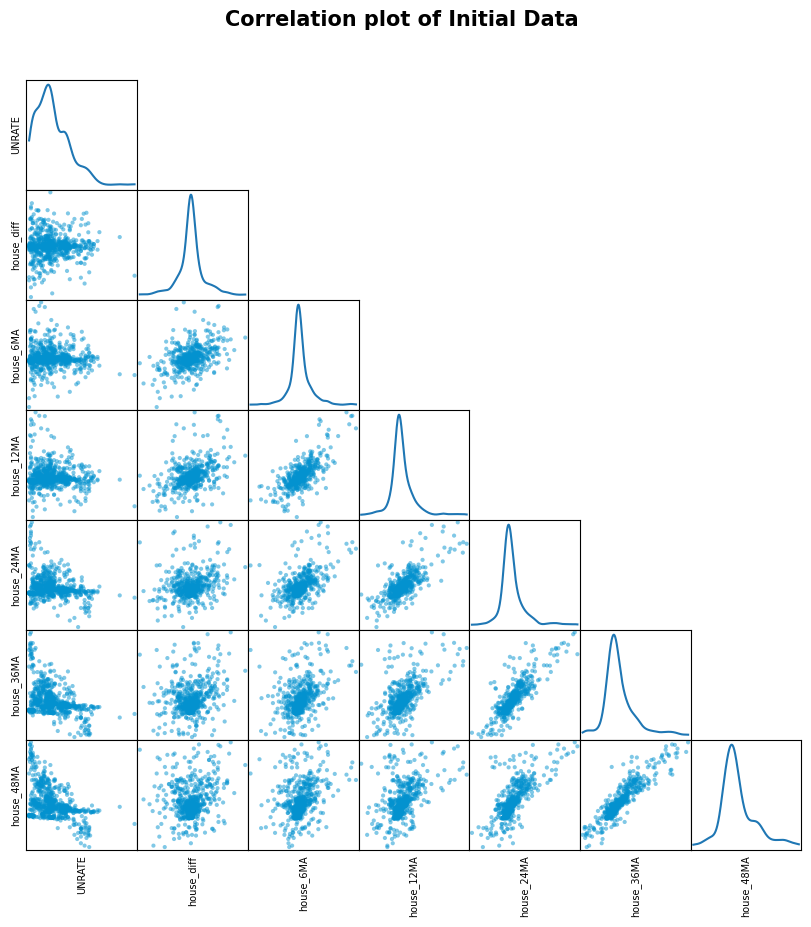

In [31]:
from matplotlib.ticker import FormatStrFormatter
from pandas.plotting import scatter_matrix
from sklearn import datasets

# rerun the correlation plot with different moving average period
master['house_6MA'] = master['house_diff'].rolling(window=6).mean()
master['house_12MA'] = master['house_diff'].rolling(window=12).mean()
master['house_24MA'] = master['house_diff'].rolling(window=24).mean()
master['house_36MA'] = master['house_diff'].rolling(window=36).mean()
master['house_48MA'] = master['house_diff'].rolling(window=48).mean()
master['house_60MA'] = master['house_diff'].rolling(window=60).mean()
#diagonal is graphed by kernel density estimation (KDE)
ax = scatter_matrix(master[['UNRATE', 'house_diff','house_6MA','house_12MA','house_24MA','house_36MA','house_48MA']], 
                    color="#0392cf", alpha=0.5, figsize=(10, 10), diagonal='kde', marker = '.')

for i in range(np.shape(ax)[0]):
    for j in range(np.shape(ax)[1]):
        if i < j:
            ax[i,j].set_visible(False)

for ax in ax.ravel():
    ax.set_xlabel(ax.get_xlabel().replace(' ', '\n'), fontsize = 7, rotation = 90, weight = 'medium')
    ax.set_ylabel(ax.get_ylabel().replace(' ', '\n'), fontsize = 7, rotation = 90, weight = 'medium')
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.yaxis.set_ticks([])
    ax.xaxis.set_ticks([])
    
plt.suptitle('Correlation plot of Initial Data',size = 15, weight = 'bold',va = 'bottom', x= 0.5, y= 0.93)

handles = [plt.plot([],[],color=plt.cm.brg(i/2.), ls="", marker="o", \
                    markersize=np.sqrt(10))[0] for i in range(3)]
handles = [handles[0],handles[2],handles[1]]
plt.show()

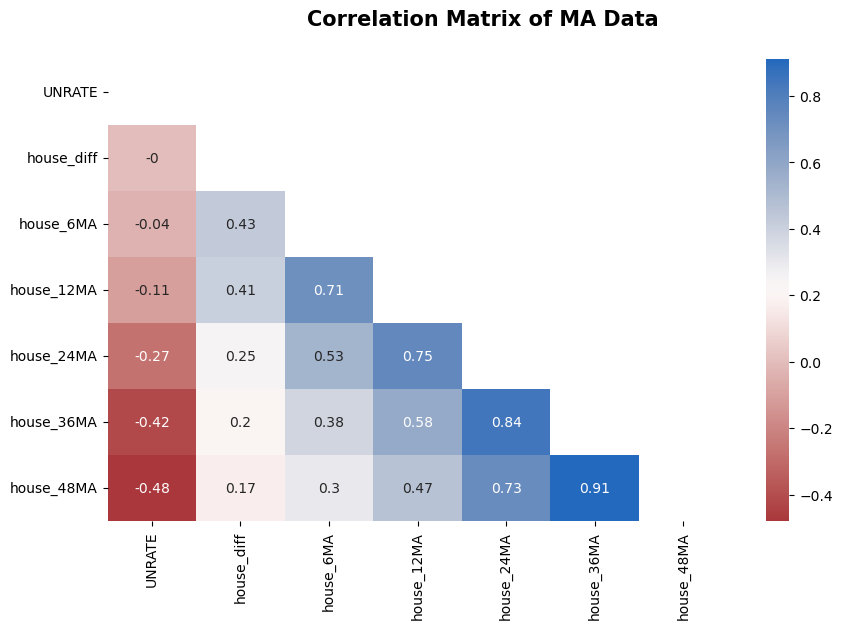

In [32]:
import seaborn as sns

# rerun the correlation matrix with different moving average period
corr_matrix = master[['UNRATE','house_diff','house_6MA','house_12MA','house_24MA','house_36MA','house_48MA']] 
np.bool = np.bool_
corr =round(corr_matrix.corr(),2)

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, annot_kws = {'size':10}, cmap = 'vlag_r', xticklabels = corr.columns.values, 
            yticklabels = corr.columns.values, annot = True, mask = mask)
heat_map = plt.gcf()
heat_map.set_size_inches(10,6)
plt.suptitle('Correlation Matrix of MA Data',size = 15, weight = 'bold',va = 'bottom', x= 0.5, y= 0.93)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.show()

# Though we know that the more look back we have the better the result, from a statistic perspect, 
# we are confident enough to say that there is a negative correlation 
# housing market price is granger cause to the unemployment rate with 11 lags

### 2. Rerun time series with lag <a name="4.2"></a>

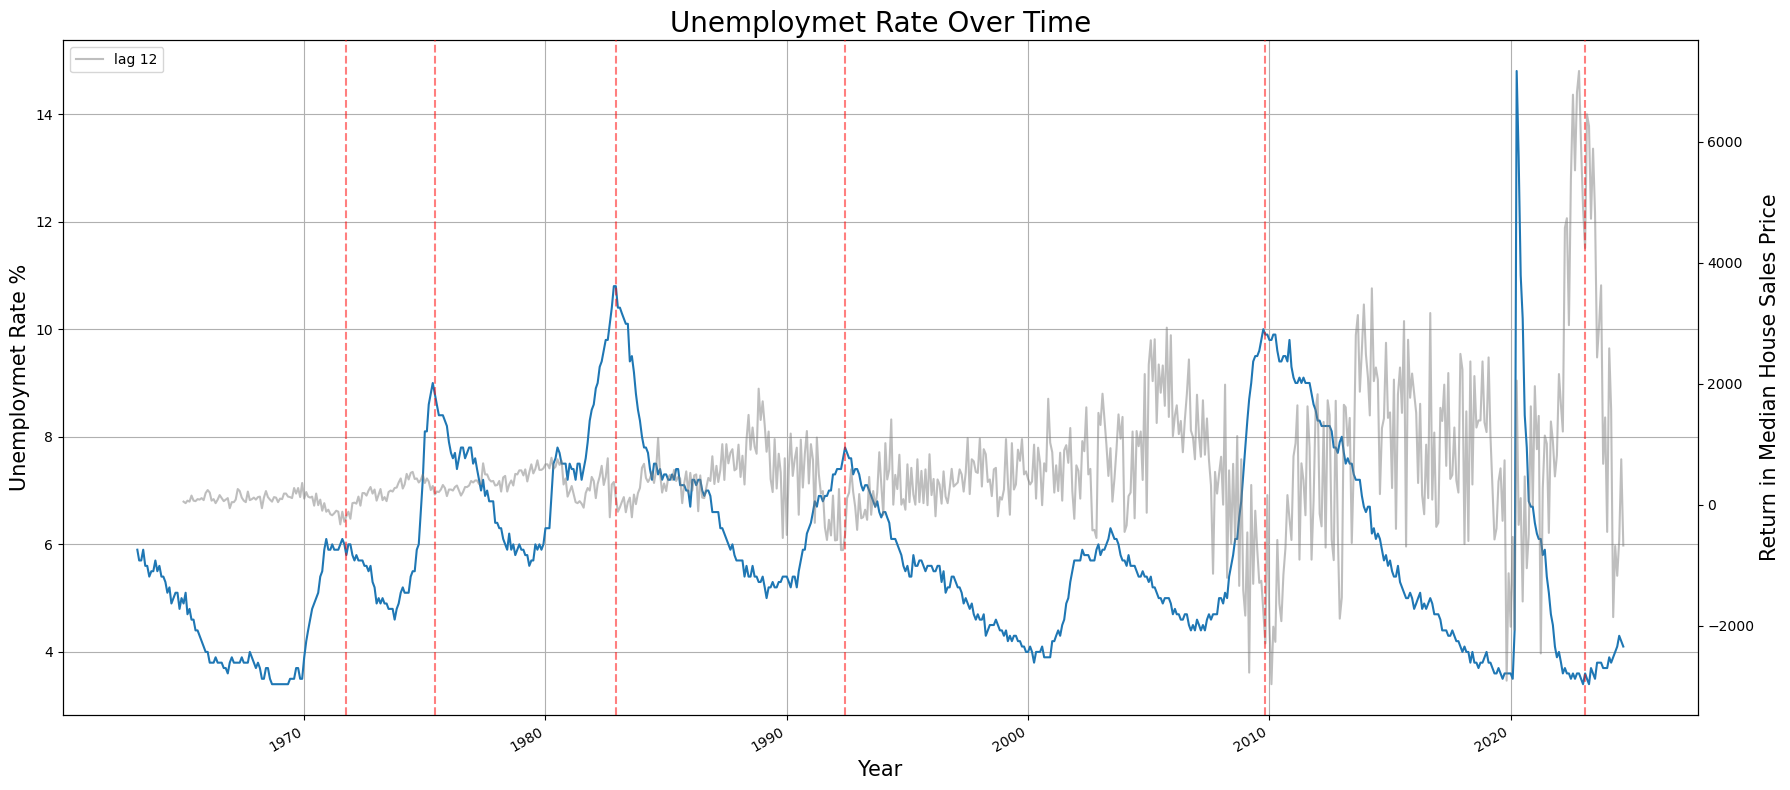

In [36]:
# rerun the time series graph with MA data to display the relationship
master['house_lag12'] = master['house_12MA'].shift(12)
fig, ax1 = plt.subplots(figsize = (18,8))
ax1.plot(master.index, 'UNRATE', data=master, color = 'tab:blue',label = 'UNRATE')

ax1.set_xlabel('Year',fontdict={'fontsize': 15, 'fontweight': 'medium'})
ax1.set_ylabel('Unemploymet Rate %',fontdict={'fontsize': 15, 'fontweight': 'medium'})
ax1.set_title('Unemploymet Rate Over Time', fontdict={'fontsize': 20, 'fontweight': 'medium'})
ax1.grid(True)

ax2 = ax1.twinx()  
ax2.plot(master.index, 'house_lag12', data=master, color = 'tab:grey', alpha=0.5,label = 'lag 12')
ax2.tick_params(axis = 'y')
ax2.set_ylabel('Return in Median House Sales Price', size = 15)
plt.legend(loc='upper left')

#Year break is unemployment peak or trough
ax3 = ax1.twinx()
break_year = np.datetime64(date(1971, 10, 1).strftime('%Y-%m-%d'))
ax3.axvline(break_year, ls='--', color='r', alpha = 0.5)
ax3.axis('off')

ax4 = ax1.twinx()
break_year = np.datetime64(date(1975, 6, 1).strftime('%Y-%m-%d'))
ax4.axvline(break_year, ls='--', color='r', alpha = 0.5)
ax4.axis('off')

ax5 = ax1.twinx()
break_year = np.datetime64(date(1982, 12, 1).strftime('%Y-%m-%d'))
ax5.axvline(break_year, ls='--', color='r', alpha = 0.5)
ax5.axis('off')

ax6 = ax1.twinx()
break_year = np.datetime64(date(1992, 6, 1).strftime('%Y-%m-%d'))
ax6.axvline(break_year, ls='--', color='r', alpha = 0.5)
ax6.axis('off')

ax7 = ax1.twinx()
break_year = np.datetime64(date(2009, 11, 1).strftime('%Y-%m-%d'))
ax7.axvline(break_year, ls='--', color='r', alpha = 0.5)
ax7.axis('off')

ax8 = ax1.twinx()
break_year = np.datetime64(date(2023, 2, 1).strftime('%Y-%m-%d'))
ax8.axvline(break_year, ls='--', color='r', alpha = 0.5)
ax8.axis('off')

fig.autofmt_xdate()
fig.tight_layout()
plt.show()